<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# МО для маркетплейса «В один клик»

Проект посвящён разработке модели машинного обучения, которая поможет маркетплейсу «В один клик» предсказывать вероятность снижения покупательской активности клиента в следующие три месяца. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

In [1]:
# устанавливаю библиотеку shap
!pip install shap 

In [2]:
# загружаю все нужные для проекта библиотеки

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
import phik

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
def load_data(file_name):
    """
    Load data from a CSV file and display its head and info.

    This function reads a CSV file, with data separated by semicolons and decimals
    denoted by commas, into a pandas DataFrame. It also displays the first few rows of the
    DataFrame (the head) and summarizes the columns.

    Parameters
    ----------
    file_name : str
        The name (and path, if necessary) of the CSV file from which to load data.

    Returns
    -------
    data : pandas.DataFrame
        The data loaded from the CSV file.
    """
    data = pd.read_csv(file_name, sep=';', decimal=',')  # разделила данные в датасете по столбцам и поправила разделитель в дробях
    print(data.head())
    data.info()
    return data

def load_data_2(file_name):
    """
    Load data from a CSV file and display its head and info.

    This function reads a CSV file, with data separated by semicolons and decimals
    denoted by commas, into a pandas DataFrame. It also displays the first few rows of the
    DataFrame (the head) and summarizes the columns.

    Parameters
    ----------
    file_name : str
        The name (and path, if necessary) of the CSV file from which to load data.

    Returns
    -------
    data : pandas.DataFrame
        The data loaded from the CSV file.
    """
    data = pd.read_csv(file_name, sep=',', decimal=',')  # разделила данные в датасете по столбцам и поправила разделитель в дробях
    print(data.head())
    data.info()
    return data

def clean_columns(data):
    """
    Cleans the column names of a pandas DataFrame.

    :param data: The pandas DataFrame to clean the column names of.
    :type data: pandas.DataFrame
    :return: The pandas DataFrame with cleaned column names.
    :rtype: pandas.DataFrame
    """
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    print(data.head())
    return data

def plot_cat_data(data, title, ax):
    """
    Plot a countplot for the given categorical data.

    Parameters
    ----------
    data : array-like
        The categorical data to be plotted as a countplot. This could be a list, 1D-array or series.
    title : string
        The title of the plot.
    ax : matplotlib.axes.Axes instance
        The axes upon which to draw the plot.

    Returns
    -------
    None
    """
    sns.countplot(x=data, ax=ax)
    ax.set_title(title)

def plot_num_data(data, title, ax):
    """
    Plot a boxplot (also known as whisker plot) for the given numerical data.

    Parameters
    ----------
    data : array-like
        The numerical data to be plotted as a boxplot. This could be a list, 1D-array or series.
    title : string
        The title of the plot.
    ax : matplotlib.axes.Axes instance
        The axes upon which to draw the plot.

    Returns
    -------
    None
    """
    sns.boxplot(data=data, ax=ax) # ящик с усами
    ax.set_title(title)

def hist_num_data(data, title, ax):
    """
    Plot a histogram of the given data.

    Parameters
    ----------
    data : array-like
        The input data to be plotted as a histogram.
    title : str
        The title to be set for the histogram.
    ax : matplotlib.axes.Axes
        The axes object on which the histogram is to be plotted.

    Returns
    -------
    None
    """
    sns.histplot(data=data, ax=ax) # гистограмма
    ax.set_title(title)

def data_for_model(data, drop_col, ohe_col, ord_col, num_col, test_size = 0.25, random_state=42, stratify = None):
    """
    Prepare data for a machine learning model. The function splits the data into training and test sets, 
    applies one-hot encoding, ordinal encoding and scaling to the appropriate columns.

    Parameters
    ----------
    data : DataFrame
        The input data to be prepared for the model.
    drop_col : list
        The columns to be dropped from the input data.
    ohe_col : list
        The columns to be one-hot encoded.
    ord_col : list
        The columns to be ordinal encoded.
    num_col : list
        The numerical columns to be scaled.
    test_size : float, optional
        The proportion of the dataset to include in the test split, by default 0.25.
    random_state : int, optional
        The seed used by the random number generator, by default 42.
    stratify : array-like, optional
        If not None, data is split in a stratified fashion, using this as the class labels.

    Returns
    -------
    X_train : DataFrame
        The training data after preprocessing.
    X_test : DataFrame
        The test data after preprocessing.
    y_train : Series
        The training labels.
    y_test : Series
        The test labels.
    scaler : MinMaxScaler
        The scaler used to scale the numerical columns.
    ohe_encoder : OneHotEncoder
        The one-hot encoder used to encode the one-hot columns.
    ord_encoder : OrdinalEncoder
        The ordinal encoder used to encode the ordinal columns.
    """

    X = data.drop(drop_col, axis=1)
    y = data[drop_col[0]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

    ohe_encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_train_ohe = ohe_encoder.fit_transform(X_train[ohe_col])
    X_test_ohe = ohe_encoder.transform(X_test[ohe_col])
    encoder_ohe_names = ohe_encoder.get_feature_names_out()
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_ohe_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_ohe_names)
    
    ord_encoder = OrdinalEncoder()
    X_train_ord = ord_encoder.fit_transform(X_train[ord_col])
    X_test_ord = ord_encoder.transform(X_test[ord_col])
    X_train_ord = pd.DataFrame(X_train_ord, columns=ord_col)
    X_test_ord = pd.DataFrame(X_test_ord, columns=ord_col)

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col])
    X_test_scaled = scaler.transform(X_test[num_col])
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col)

    X_train = pd.concat([X_train_ohe, X_train_ord, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_ord, X_test_scaled], axis=1)

    return X_train, X_test, y_train, y_test, scaler, ohe_encoder, ord_encoder


Написала две функции для выгрузки значений, потому что load_data с разделителем ';' почему-то ломает структуру в таблицах market_money и market_time, хотя там изначально не было проблем с выводом таблицы.

## Загрузка и изучение данных

In [4]:
client_info = load_data_2('/Users/ira-bobrineva/Downloads/market_file.csv')

       id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

  Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность Акционные_покупки  \
0                3.4                     5           121               0.0   
1                4.4                     4           819              0.75   
2                4.9                     3           539              0.14   
3                3.2                     5           896              0.99   
4                5.1                     3          1064              0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                         

In [5]:
client_revenue_per_month = load_data_2('/Users/ira-bobrineva/Downloads/market_money.csv')

       id               Период Выручка
0  215348  препредыдущий_месяц     0.0
1  215348        текущий_месяц  3293.1
2  215348     предыдущий_месяц     0.0
3  215349  препредыдущий_месяц  4472.0
4  215349        текущий_месяц  4971.6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3900 non-null   int64 
 1   Период   3900 non-null   object
 2   Выручка  3900 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.5+ KB


In [6]:
client_time = load_data_2('/Users/ira-bobrineva/Downloads/market_time.csv')

       id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [7]:
revenue_sum = load_data('/Users/ira-bobrineva/Downloads/money.csv')


       id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


В таблицах client_info и client_revenue_per_month надо поправить типы данных в некоторых столбцах. Надо привести названия столбцов к одному виду + проверить значения в столбцах с object-значениями. Например, в 'типе сервиса' есть ошибка в написании типа 'стандарт'. Пропусков в значениях нет.

## Предобработка 

### Обработка названий переменных

In [8]:
client_info = clean_columns(client_info)


       id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

  маркет_актив_6_мес  маркет_актив_тек_мес  длительность акционные_покупки  \
0                3.4                     5           121               0.0   
1                4.4                     4           819              0.75   
2                4.9                     3           539              0.14   
3                3.2                     5           896              0.99   
4                5.1                     3          1064              0.94   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     Товары для детей                         

In [9]:
client_revenue_per_month = clean_columns(client_revenue_per_month)

       id               период выручка
0  215348  препредыдущий_месяц     0.0
1  215348        текущий_месяц  3293.1
2  215348     предыдущий_месяц     0.0
3  215349  препредыдущий_месяц  4472.0
4  215349        текущий_месяц  4971.6


In [10]:
client_time = clean_columns(client_time)

       id            период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13


In [11]:
revenue_sum = clean_columns(revenue_sum)

       id  прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21


### Обработка типов данных

In [12]:
# создаю цикл, чтобы поправить типы данных
for i in ('маркет_актив_6_мес', 'акционные_покупки'):
    client_info[i] = client_info[i].astype('float32')

client_revenue_per_month['выручка'] = client_revenue_per_month['выручка'].astype('float32')

client_info.info()
client_revenue_per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float32
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float32
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

### Обработка неявных дубликатов

In [13]:
client_info['тип_сервиса'].value_counts()

тип_сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64

Поправлю значение 'стандартт', уберу тем самым неявный дубликат.

In [14]:
client_info['тип_сервиса'] = client_info['тип_сервиса'].replace('стандартт', 'стандарт')
client_info['тип_сервиса'].value_counts()

тип_сервиса
стандарт    924
премиум     376
Name: count, dtype: int64

In [15]:
client_info['популярная_категория'].value_counts()

популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64

In [16]:
client_info['популярная_категория'] = client_info['популярная_категория'].str.replace('аксесуары', 'аксессуары') # убираю ошибку в названии категории
client_info['популярная_категория'].value_counts()

популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксессуары                  223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64

In [17]:
client_revenue_per_month['период'].value_counts()

период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

In [18]:
client_revenue_per_month['период'] = client_revenue_per_month['период'].str.replace('препредыдущий', 'предпредыдущий') # убираю ошибку в названии периода
client_revenue_per_month['период'].value_counts()

период
предпредыдущий_месяц    1300
текущий_месяц           1300
предыдущий_месяц        1300
Name: count, dtype: int64

In [19]:
client_time['период'].value_counts()

период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: count, dtype: int64

In [20]:
client_time['период'] = client_time['период'].str.replace('предыдцщий', 'предыдущий') # убираю ошибку в названии периода
client_time['период'].value_counts()

период
текущий_месяц       1300
предыдущий_месяц    1300
Name: count, dtype: int64

Полных дубликатов в данных нет.

## Исследовательский анализ

### Распределение категориальных признаков

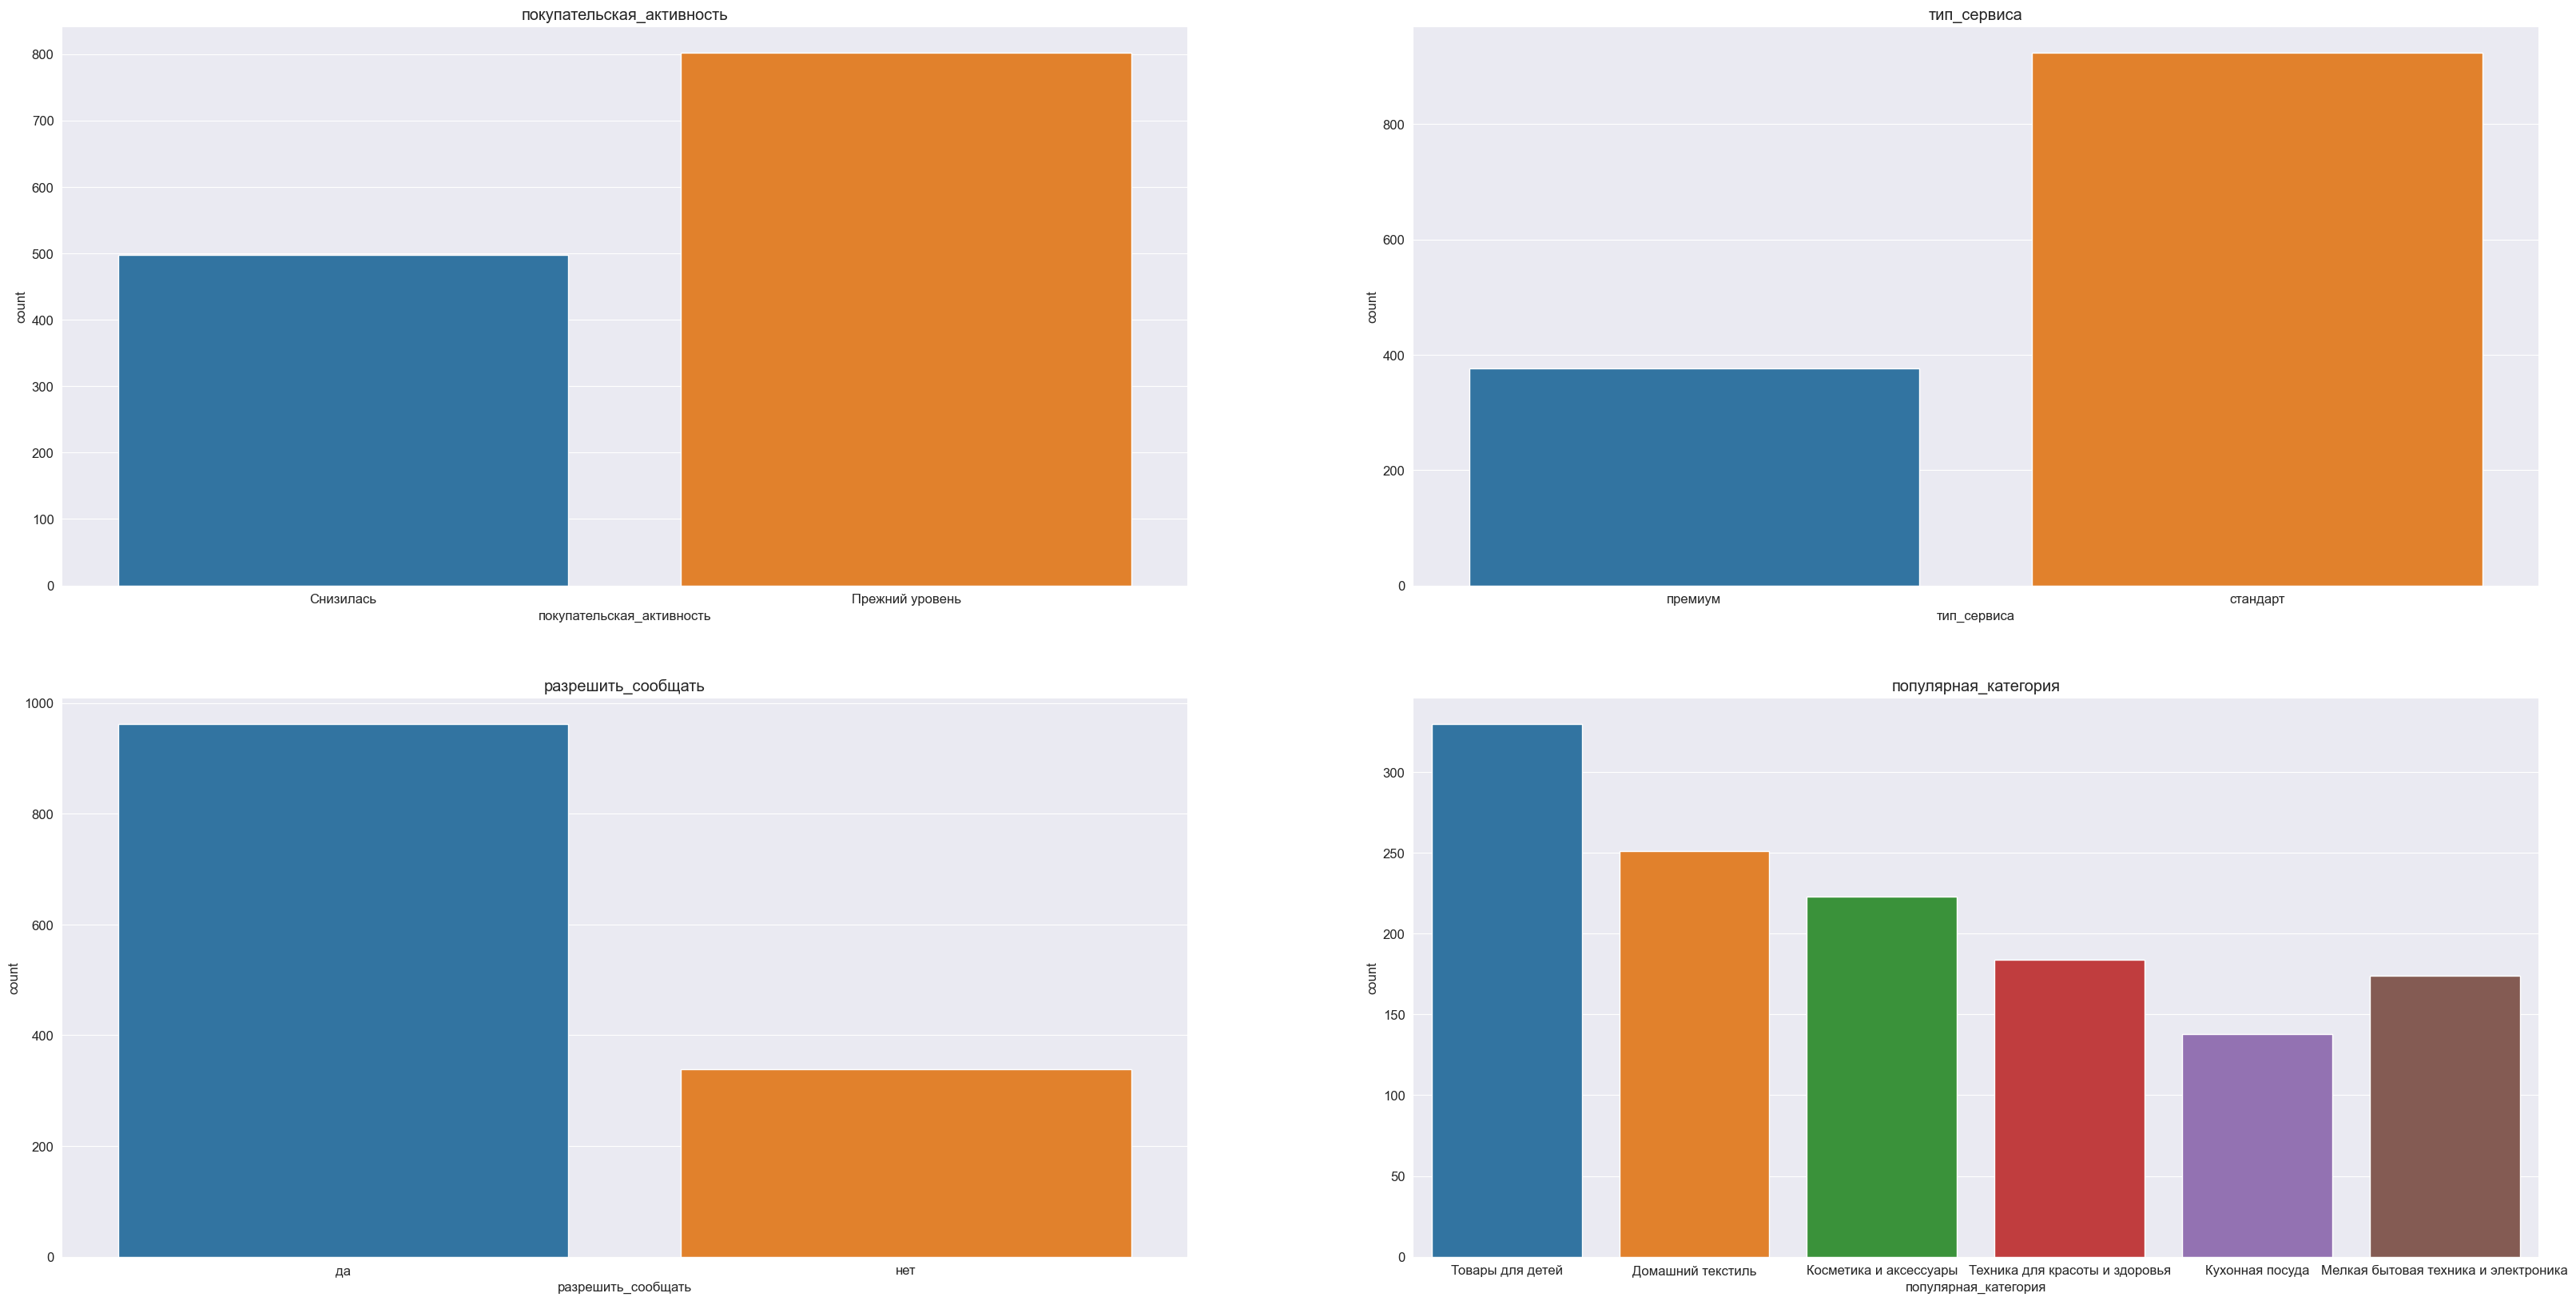

In [21]:
# делаю срез только с категориальными признаками
client_info_cat = client_info[['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'популярная_категория']]

plt.rcParams.update({'font.size': 12})
# создаю subplots
fig, axs = plt.subplots(2, 2, figsize=(40, 20))

axs = axs.flatten()

for i, cat in enumerate(client_info_cat):
    # строю столбчатые диаграммы
    plot_cat_data(client_info_cat[cat], cat, axs[i])

В распределении признаков наблюдается небольшой дисбаланс, при обучении нужно будет стратифицировать данные.

### Распределение количественных признаков


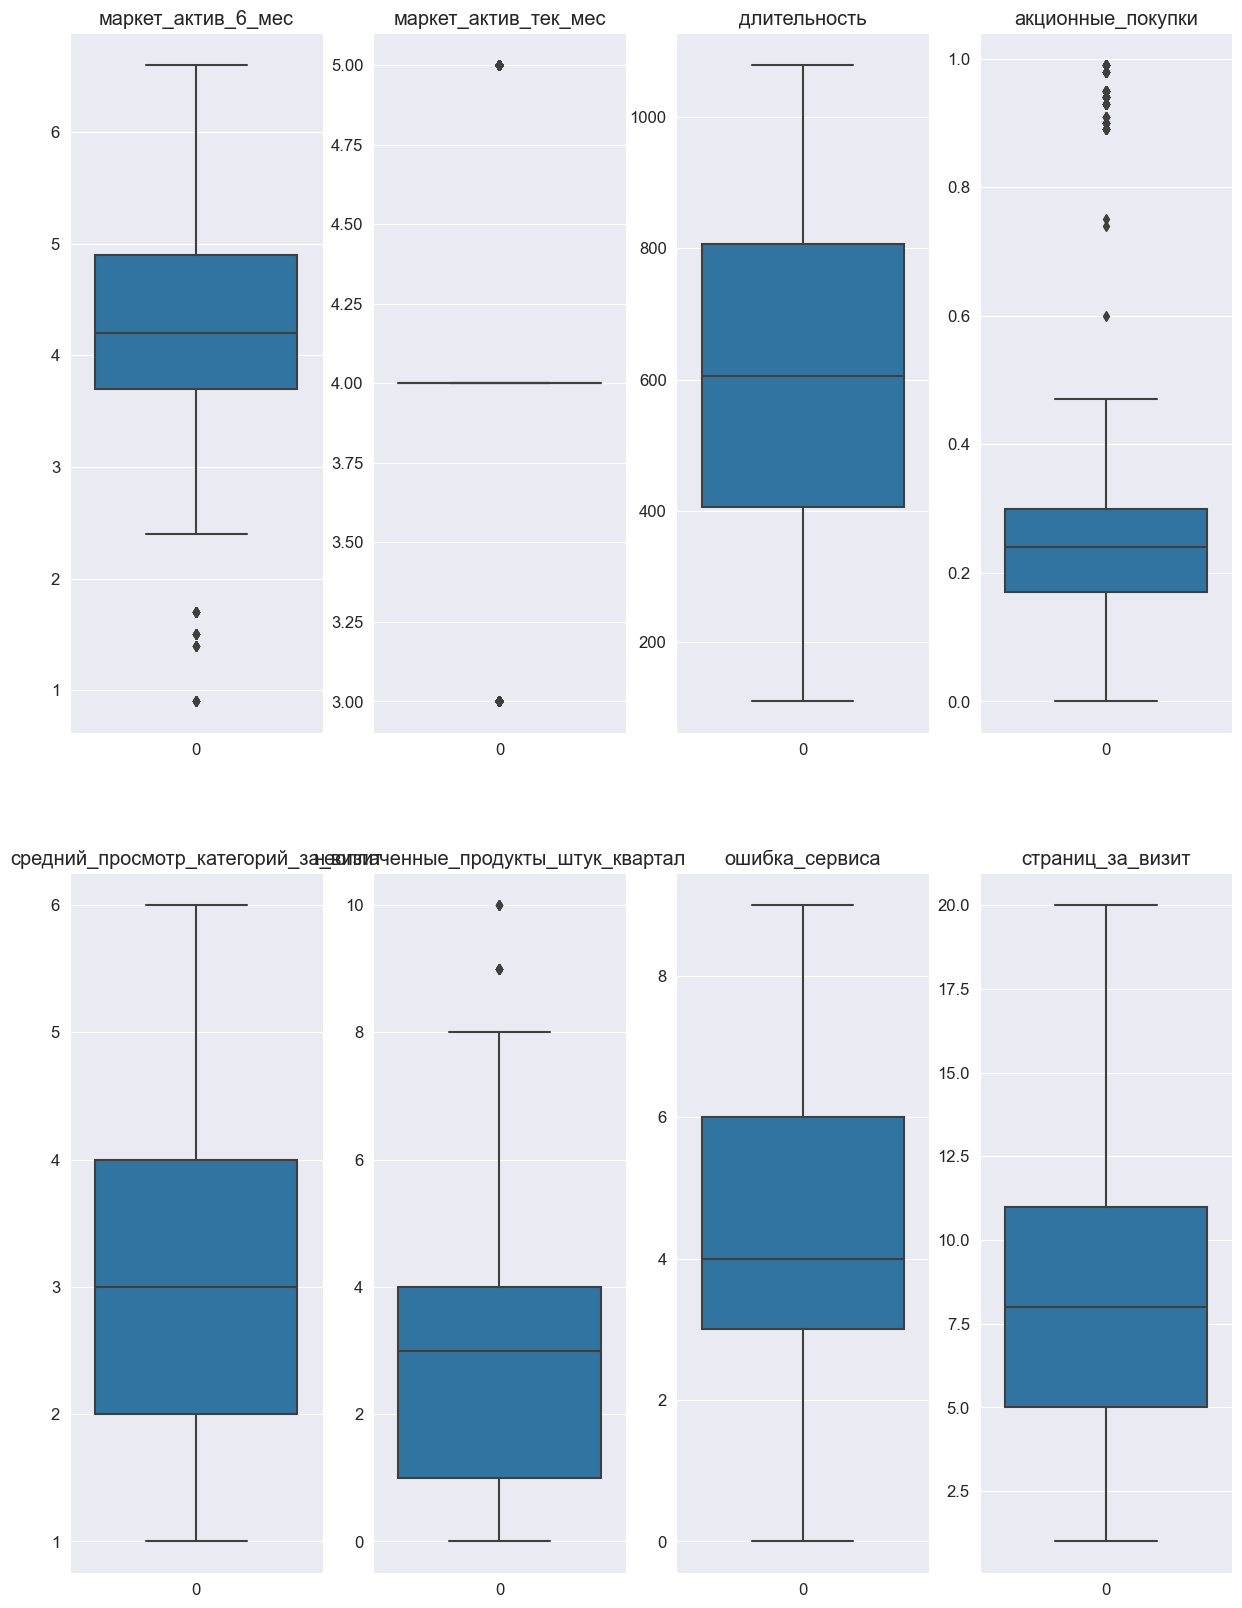

In [22]:
# выведу распределения по каждому количественному показателю в client_info, чтобы детальнее на них посмотреть

client_info_num = client_info[['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']]

fig, axs = plt.subplots(2, 4, figsize=(15, 20))

axs = axs.flatten()

for i, num in enumerate(client_info_num):
    # построение гистограммы
    plot_num_data(data=client_info_num[num], title=num, ax=axs[i])

В датафрейме, на котором будут обучаться модели, количественные признаки разных размеров. Их нужно будет привести к одному масштабу.

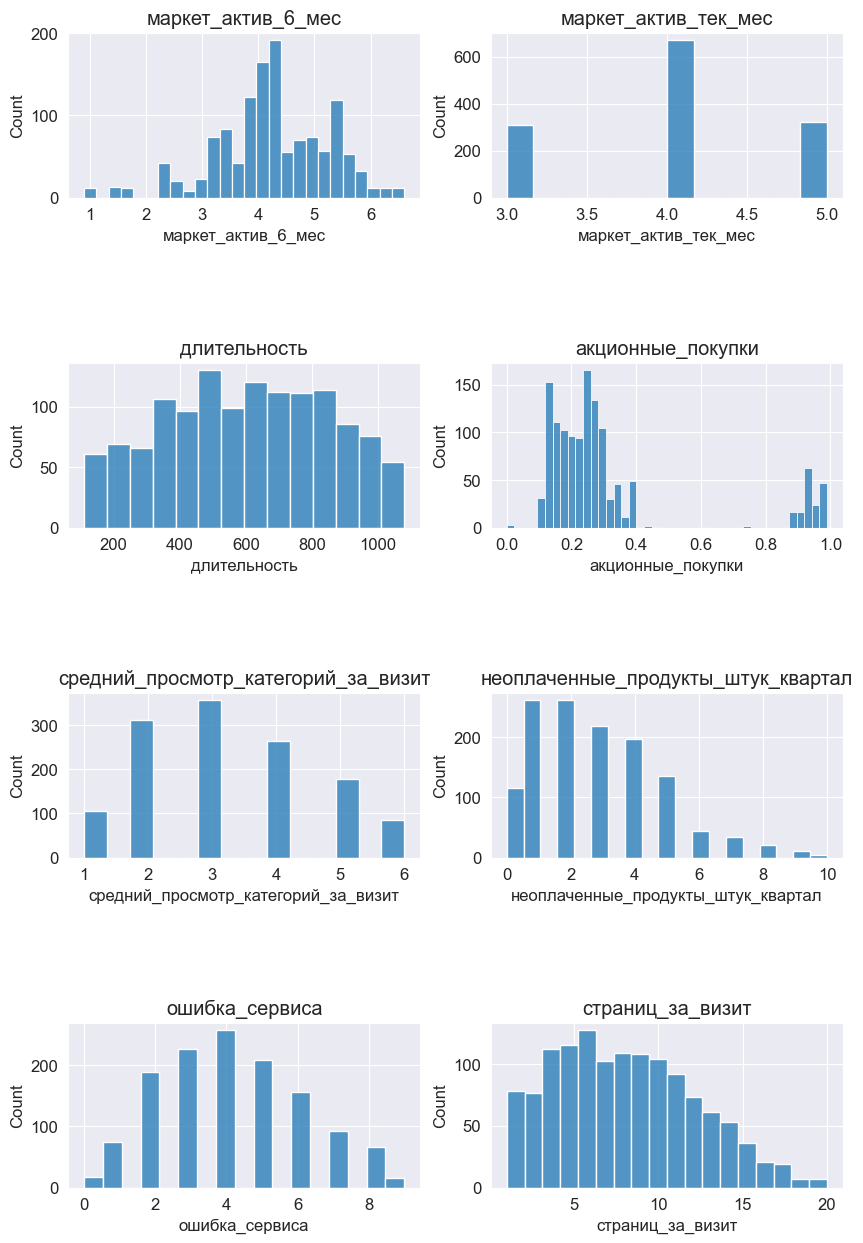

In [23]:
# отдельно посмотрю на гистограммы по каждому показателю в client_info

fig, axs = plt.subplots(4, 2, figsize=(10, 15))

axs = axs.flatten()

for i, num in enumerate(client_info_num):
    # построение гистограммы
    hist_num_data(client_info_num[num], num, axs[i])
    
fig.subplots_adjust(hspace = 1)


Не все признаки распределены нормально + некоторые признаки больше похожи на категориальные.

In [24]:
# посмотрю на распределение выручки по периодам
revenue_per_month = client_revenue_per_month.groupby('период')['выручка'].sum().sort_values(ascending=False)
revenue_per_month

период
текущий_месяц           6909449.0
предыдущий_месяц        6417996.5
предпредыдущий_месяц    6272769.0
Name: выручка, dtype: float32

Выручка с каждого пользователя за три месяца постепенно выросла. В текущем месяце выручка больше, чем в предыдущем месяце. Значит, снижение активности пока не отразилось на доходах магазина, но может в будущем.

In [25]:
# посмотрю на распределение времени по периодам
time_per_month = client_time.groupby('период')['минут'].sum().sort_values(ascending=False)
time_per_month

период
предыдущий_месяц    17508
текущий_месяц       17166
Name: минут, dtype: int64

Снизилось общее время, которое покупатели проводят на сайте в течение периода.

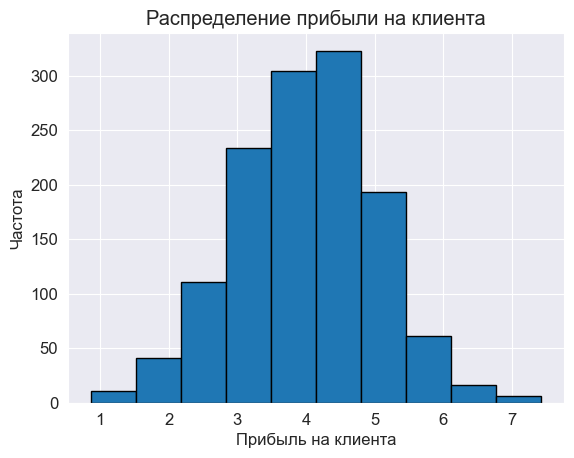

In [26]:
# посмотрю на общее распределение выручки по клиентам
plt.hist(revenue_sum['прибыль'], bins=10, edgecolor='black')
plt.xlabel('Прибыль на клиента')
plt.ylabel('Частота')
plt.title('Распределение прибыли на клиента')
plt.show()

- В данных разные диапазоны значений. Перед тем как обучать модуль на признаках, эти признаки надо с помощью масштабирования привести к одному диапазону.
- В данных много переменных с целыми значениями, можно попробовать сделать их категориальными значениями. 
- Не все признаки распределены нормально, для изучения корреляции стоит использовать коэффициент Спирмана.

### Клиенты с покупательской активностью не менее трёх месяцев

In [27]:
# отберу тех клиентов, у которых хотя бы в одном месяце выручка была равна 0
active_clients_3month = client_revenue_per_month.query('выручка == 0')
active_clients_3month


,id,период,выручка
0,215348,предпредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,предпредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,предпредыдущий_месяц,0.0


In [28]:
# выведу уникальных клиентов
active_clients_3month['id'].unique()

array([215348, 215357, 215359])

В данных нет пользователей, которые бы не были активны в течение трёх месяцев. Каждый из покупателей приносил выручку магазину хотя бы в одном месяце. Есть три клиента, которые не покупали в предпредыдущем и предыдущем месяцах, но в текущем месяце они совершали покупки.  

## Объединение таблиц

In [29]:
# использую функцию pivot_table для преобразования значений столбца 'период' в новые столбцы
client_revenue_per_month = client_revenue_per_month.pivot_table(index='id', columns='период', values='выручка', aggfunc='first')

# сбрасываю индекс, чтобы 'id' стал обычным столбцом
client_revenue_per_month = client_revenue_per_month.reset_index()

columns_to_modify = ['предпредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']

# чуть переименую столбцы

for col in columns_to_modify:
    if col in client_revenue_per_month.columns:
        client_revenue_per_month.rename(columns={col: 'выручка_' + col}, inplace=True)

client_revenue_per_month



период,id,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
0,215348,0.0,0.0,3293.100098
1,215349,4472.0,5216.0,4971.600098
2,215350,4826.0,5457.5,5058.399902
3,215351,4793.0,6158.0,6610.399902
4,215352,4594.0,5807.5,5872.500000
...,...,...,...,...
1295,216643,4704.0,3664.0,4741.700195
1296,216644,5299.0,4729.0,5353.000000
1297,216645,5334.0,5160.0,5139.200195
1298,216646,4725.0,4923.0,5224.600098


In [30]:
# использую функцию pivot_table для преобразования значений столбца 'период' в новые столбцы
client_time = client_time.pivot_table(index='id', columns='период', values='минут', aggfunc='first')
# сбрасываю индекс, чтобы 'id' стал обычным столбцом
client_time = client_time.reset_index()

columns_to_modify_2 = ['предыдущий_месяц', 'текущий_месяц']

for col in columns_to_modify_2:
    if col in client_time.columns:
        client_time.rename(columns={col: 'минуты_' + col}, inplace=True)

client_time

период,id,минуты_предыдущий_месяц,минуты_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11
...,...,...,...
1295,216643,14,7
1296,216644,12,11
1297,216645,12,18
1298,216646,18,7


In [31]:
# объединяю все таблицы
info = client_info.merge(client_time, on='id')
info

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,14,7
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,12,11
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,12,18
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,18,7


In [32]:
data = info.merge(client_revenue_per_month, on='id')
data

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,13,14,0.0,0.0,3293.100098
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,4472.0,5216.0,4971.600098
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,4826.0,5457.5,5058.399902
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,4793.0,6158.0,6610.399902
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11,4594.0,5807.5,5872.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,14,7,4704.0,3664.0,4741.700195
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,12,11,5299.0,4729.0,5353.000000
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,12,18,5334.0,5160.0,5139.200195
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,18,7,4725.0,4923.0,5224.600098


## Корреляционный анализ

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц', 'выручка_предпредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']


<Axes: >

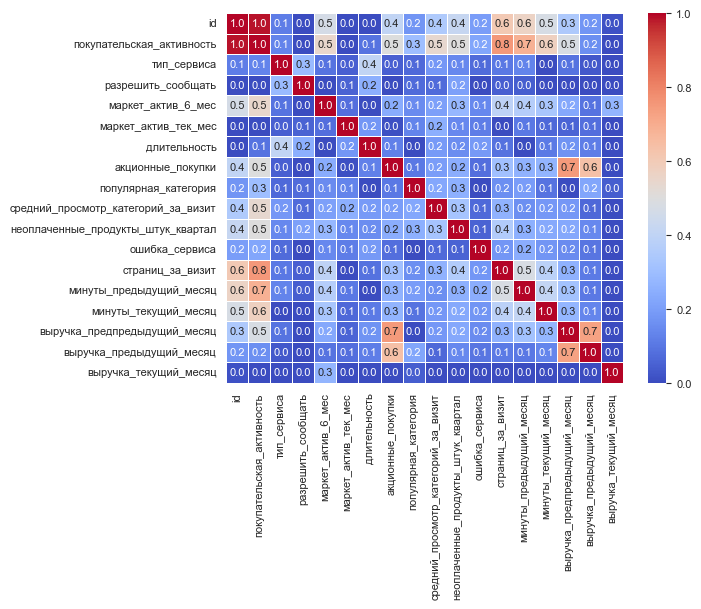

In [33]:
phik_matrix = data.phik_matrix()
plt.rcParams['font.size'] = '8'
sns.heatmap(phik_matrix, annot=True, linewidth=.5, fmt=".1f", cmap='coolwarm')

Мультиколлинеарности между входными признаками не наблюдается, коэффициенты корреляции между ними ниже 0.9. Перед обучением модели удалю на всякий случай строку с id, потому что у неё сильная корреляция с целевым признаком. Для обучения id не нужно. 

In [34]:
# полностью удалить столбец с id из датасета нельзя, поэтому сделаю из id индексы
data.set_index('id', inplace=True)

## Использование пайплайнов

Потребуются следующие преобразования значений перед обучением: 
- Кодировка 'тип_сервиса', 'разрешить_сообщать' с помощью OneHotEncoder. 
- Кодировка 'маркет_актив_тек_мес', 'популярная_категория', 'средний_просмотр_категорий_за_визит' c помощью OrdinalEncoder
- Кодировка 'маркет_актив_6_мес', 'акционные_покупки', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц' с помощью MinMaxSxaler
- Кодировка 'длительность', 'выручка_предпредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц' с помощью StandardScaler

Для проверки качества модели выбрала метрику ROC_AUC, потому что стоит задача бинарной классификации, а также есть дисбаланс в классах.

UPD: я попыталась добавить два кодировщика в пайплайн: 
‘preprocessor__standard’: [StandardScaler(), MinMaxScaler(), RobustScaler(), ‘passthrough’], 
‘preprocessor__minmax’: [StandardScaler(), MinMaxScaler(), RobustScaler(), ‘passthrough’]
Выполнение модели висело более получаса. После этого я указала только один скейлер - StandardScaler. Это я что-то не так сделала или действительно надо было подождать чуть побольше? Или была какая-то другая задумка?


In [35]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

le = LabelEncoder()
data['покупательская_активность'] = le.fit_transform(data['покупательская_активность'])

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['покупательская_активность'], axis=1),
    data['покупательская_активность'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = data['покупательская_активность']
)


ohe_columns = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
ord_columns = ['маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит']
num_columns = ['маркет_актив_6_мес', 'акционные_покупки', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц', 'длительность', 'выручка_предпредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']

ohe_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

ord_pipe = Pipeline([('ord', OrdinalEncoder(categories=[['3', '4', '5'], ['1', '2', '3', '4', '5', '6']]))])

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {

        'models': [KNeighborsClassifier()],

        'models__n_neighbors': range(1, 20),
        #
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'models__C': [0.1,1,10,100],
        'models__gamma': [0.1,1,10,100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_distributions,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

result = pd.DataFrame(randomized_search.cv_results_)
print(result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score'))

pd.set_option('display.expand_frame_repr', 250)


   rank_test_score                                       param_models  \
9                1  SVC(C=0.1, gamma=10, kernel='linear', random_s...   
1                2                             KNeighborsClassifier()   
5                3  SVC(C=0.1, gamma=10, kernel='linear', random_s...   
2                4                             KNeighborsClassifier()   
7                5  SVC(C=0.1, gamma=10, kernel='linear', random_s...   
0                6  SVC(C=0.1, gamma=10, kernel='linear', random_s...   
3                7  SVC(C=0.1, gamma=10, kernel='linear', random_s...   
6                8            DecisionTreeClassifier(random_state=42)   
4                9            DecisionTreeClassifier(random_state=42)   
8               10  SVC(C=0.1, gamma=10, kernel='linear', random_s...   

   mean_test_score                                             params  
9         0.903684  {'preprocessor__num': MinMaxScaler(), 'models_...  
1         0.901674  {'preprocessor__num': StandardSc

Лучшая модель - SVC со следующими гиперпараметрами: C=0.1, gamma=10, kernel='linear', MinMaxScaler().

In [36]:
drop_col = ['покупательская_активность']
ohe_col = ['тип_сервиса', 'разрешить_сообщать']
ord_col = ['маркет_актив_тек_мес', 'популярная_категория', 'средний_просмотр_категорий_за_визит']
num_col = ['маркет_актив_6_мес', 'акционные_покупки', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'минуты_предыдущий_месяц', 'минуты_текущий_месяц', 'длительность', 'выручка_предпредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']

X_train_best, X_test_best, y_train_best, y_test_best, scaler_best, ohe_encoder_best, ord_encoder_best = data_for_model(data, drop_col, ohe_col, ord_col, num_col, test_size = 0.25, random_state=42, stratify = data['покупательская_активность'])

# создаю объект для работы с моделью
model = SVC(kernel = 'linear', C=0.1, gamma=10, probability=True)

# обучаю модель на данных
model = model.fit(X_train_best, y_train_best)

# смотрю ещё на то, каким классам какие метки даёт модель, понадобится потом для вычисления вероятности снижения активности

model.classes_


array([0, 1])

In [37]:
# вывожу предсказания, добавлю их в итоговую валидационную таблицу 
predictions = model.predict(X_test_best)
predictions

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,

In [38]:
# вывожу вероятность значения 1, то есть значения 'Снизилась'
probabilities = model.predict_proba(X_test_best)
positive_probabilities = probabilities[:, 1]
positive_probabilities

array([2.17336122e-02, 5.49787681e-02, 9.69162303e-01, 2.26458132e-01,
       2.66361200e-01, 9.94410147e-01, 1.91640731e-02, 1.72524230e-02,
       2.96601067e-01, 9.45799262e-01, 2.50584035e-01, 9.50139400e-02,
       1.29738984e-01, 6.08343308e-02, 2.94809613e-02, 8.23261606e-01,
       1.10038833e-01, 1.05960537e-02, 5.17292360e-02, 8.74410030e-01,
       2.44362816e-02, 3.04789080e-01, 7.03578725e-02, 7.31732322e-01,
       1.66974147e-02, 7.36893191e-01, 5.20594232e-01, 3.02911547e-01,
       5.06543401e-02, 8.41756475e-01, 6.94617905e-01, 8.61537462e-01,
       1.26563023e-01, 5.00000000e-01, 5.05189230e-03, 5.05312163e-02,
       1.30434545e-02, 3.84348855e-02, 6.44229157e-02, 1.01557722e-02,
       2.32406989e-02, 8.72807840e-01, 6.80449279e-01, 3.70640185e-01,
       4.82446500e-02, 8.54092223e-01, 9.40467429e-01, 2.78344369e-02,
       2.88886123e-01, 4.13313851e-02, 6.98198613e-03, 4.07501831e-03,
       6.11741232e-02, 8.96406138e-01, 9.74804357e-02, 4.90218742e-02,
      

In [39]:
# добавляю предсказания и вероятность метки 1 в общую валидационную таблицу, чуть настроила значения в колонках
data_predictions = X_test_best.copy()
data_predictions['активность_снизится'] = predictions
data_predictions['вероятность_снижения'] = positive_probabilities
data_predictions['активность_снизится'] = data_predictions['активность_снизится'].replace({'Прежний уровень': 'Нет', 'Снизилась': 'Да'})
data_predictions

,тип_сервиса_стандарт,разрешить_сообщать_нет,маркет_актив_тек_мес,популярная_категория,средний_просмотр_категорий_за_визит,маркет_актив_6_мес,акционные_покупки,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,длительность,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,активность_снизится,вероятность_снижения
0,1.0,0.0,1.0,1.0,2.0,0.649123,0.242424,0.2,0.777778,0.684211,0.666667,0.842105,0.069358,0.895815,0.727709,0.482869,0,0.021734
1,1.0,0.0,1.0,0.0,1.0,0.807018,0.242424,0.3,0.666667,0.842105,0.722222,0.368421,0.975155,0.875684,0.759444,0.557839,0,0.054979
2,1.0,0.0,2.0,5.0,1.0,0.543860,0.393939,0.4,0.555556,0.052632,0.055556,0.421053,0.525880,0.800283,0.480239,0.113119,1,0.969162
3,1.0,0.0,1.0,0.0,4.0,0.912281,0.262626,0.2,0.555556,0.473684,0.166667,0.210526,0.872671,0.882748,0.828372,0.726308,0,0.226458
4,1.0,0.0,2.0,1.0,3.0,0.666667,0.232323,0.3,0.555556,0.263158,0.555556,0.421053,0.412008,0.866325,0.733605,0.501220,0,0.266361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,1.0,0.0,0.0,5.0,2.0,0.807018,0.141414,0.2,0.666667,0.526316,0.833333,0.631579,0.784679,0.931662,0.839362,0.537544,0,0.012061
321,1.0,0.0,2.0,4.0,3.0,0.561404,0.151515,0.2,0.444444,0.789474,0.500000,0.473684,0.534161,0.913473,0.546328,0.466761,0,0.038404
322,0.0,0.0,1.0,4.0,1.0,0.754386,0.282828,0.2,0.444444,0.578947,0.555556,0.947368,0.902692,0.790924,0.593056,0.356359,0,0.071754
323,1.0,1.0,0.0,0.0,2.0,0.912281,0.474747,0.1,0.222222,0.578947,0.444444,0.473684,0.209110,0.974395,0.775093,0.501537,0,0.109396


## Анализ важности признаков

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


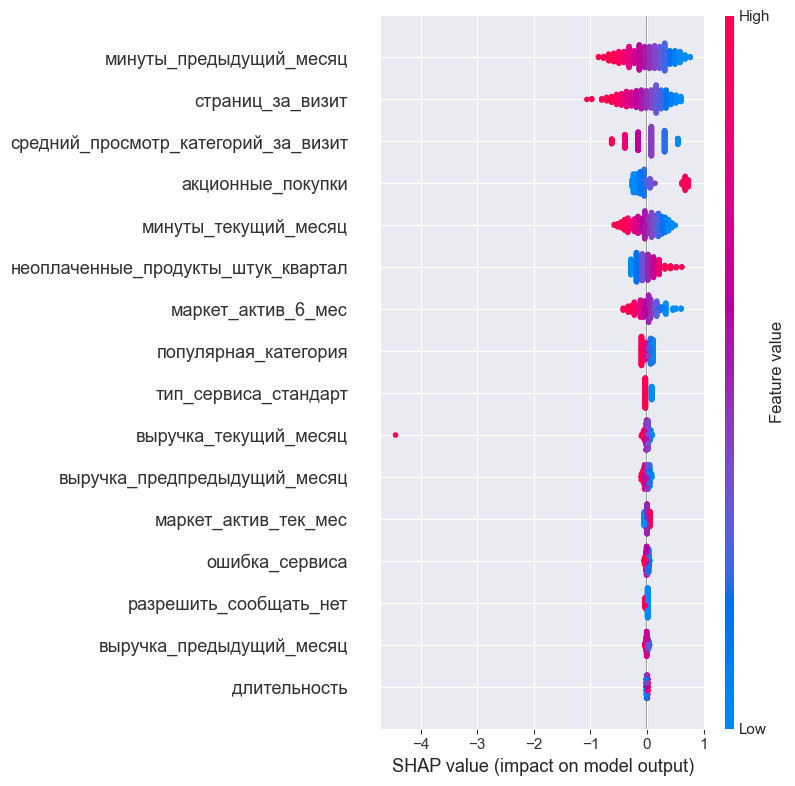

In [40]:
explainer = shap.LinearExplainer(model, X_train_best)
shap_values = explainer(X_test_best)

shap.summary_plot(shap_values, X_test_best)


На целевой признак сильно влияют признаки от 'минуты_предыдущий_месяц' до 'маркет_актив_6_мес'. Предсказуемо, что клиенты, которые проводят много времени на сайте, просматривают много категорий и активны в предыдущие месяцы, продолжат быть лояльными потребителями. Чем больше у клиента купленных акционных товаров и неоплаченных продуктов в корзине, тем выше вероятность снижения его активности в следующие месяцы. 

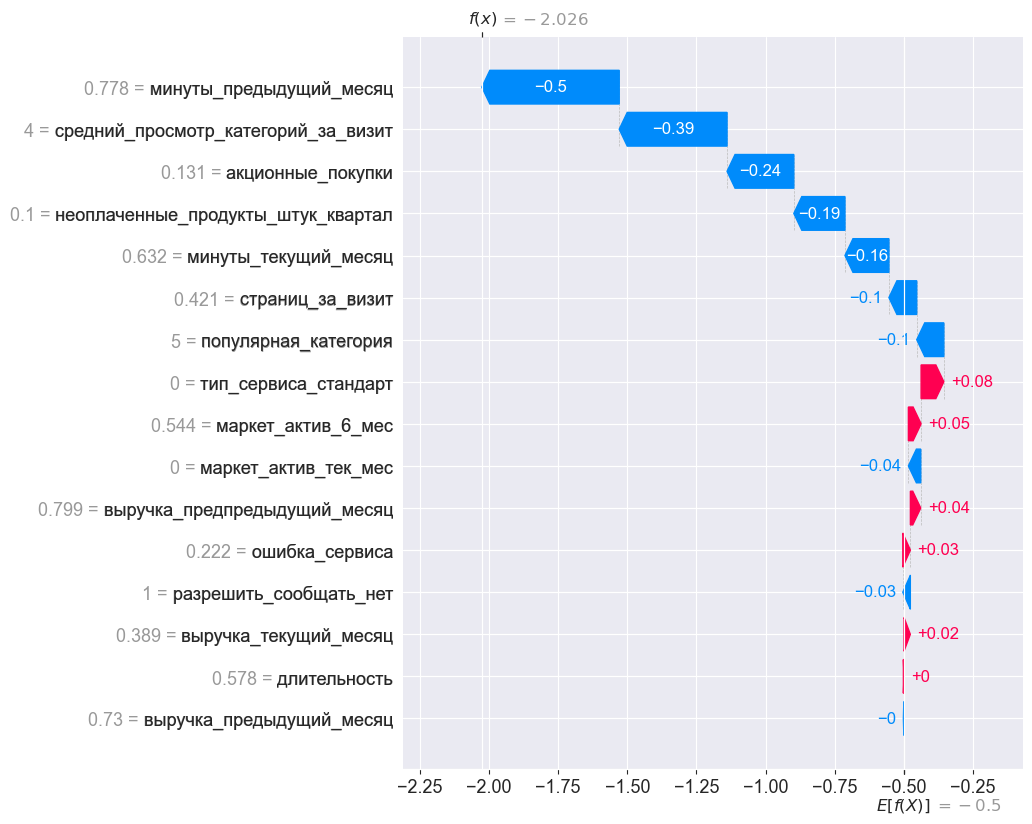

In [41]:
shap.plots.waterfall(shap_values[6], max_display = 18)

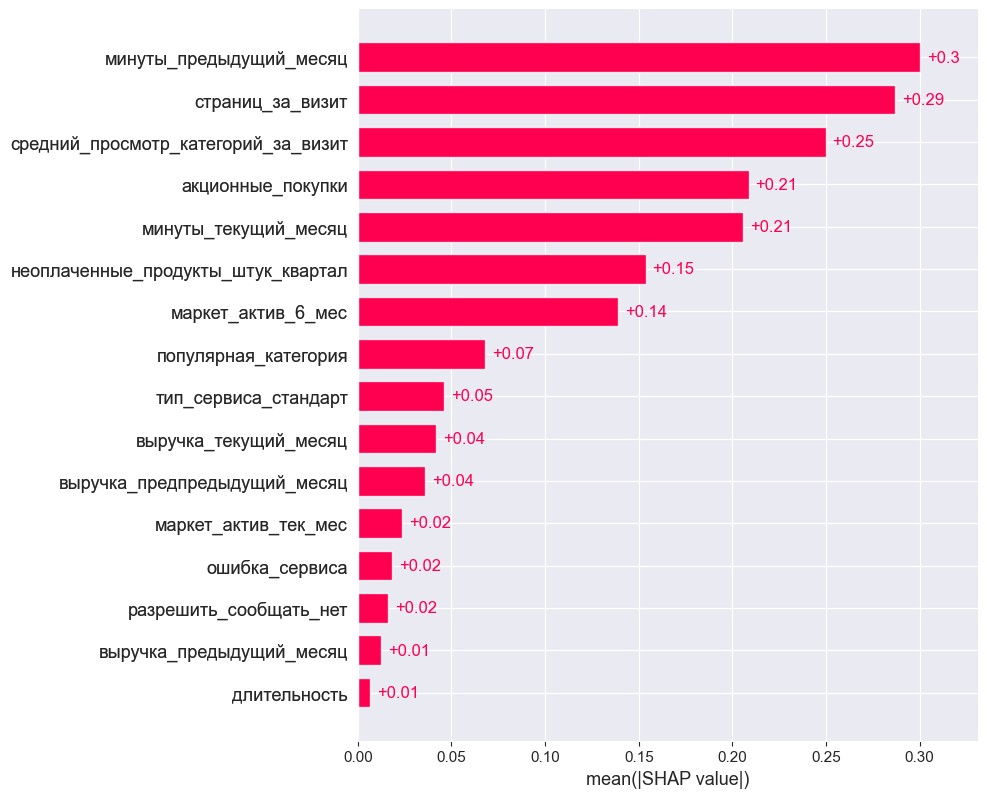

In [42]:
shap.plots.bar(shap_values, max_display = 18)

Сильнее всего на классификацию влияет признак 'минуты_предыдущий_месяц'. У него и вес самый большой. Модель считает, что чем больше провёл клиент на сайте в предыдущий месяц, тем больше у него вероятность остаться активным в следующие месяцы. Вот тут у меня закралось сомнение: что если этот признак не нужен для расчёта вероятности активности в будущем? Может, стоит только оставить показатель за текущий месяц? Логично кажется, что больше должен текущий месяц влиять на решение, чем предыдущий. А предыдущий так сильно может влиять, потому что у него значения больше, чем у текущего.

## Сегментация покупателей

### Клиенты, которые покупают только технику

Тут вот я, скорее всего, допускаю ошибку. Выше я удалила все айдишники клиентов из датасета для обучения, потому что они сильно коррелировали с целевым признаком. Поэтому я не могу просто присоединить к валидационной таблице значения прибыли по айди клиентов. Я сделала костыль: сложила все значения выручки по месяцам и вывела их как общую прибыль по клиентам. Но эти значения также были масштабированы и, возможно, как-то по-другому рассчитывались. Из-за этого scatter plot тоже своеобразный получается. Вывод сделать можно, но не уверена, что он будет верным) Подскажи, пожалуйста, тут: верно ли, что я удалила айди из датасета? нужно ли их вернуть затем в валидационную выборку, чтобы нормально присоединить данные по прибыли? 

In [43]:
# костяляю тут новый столбец с общей выручкой
data_predictions['общая_выручка'] = data_predictions['выручка_предпредыдущий_месяц'] + data_predictions['выручка_предыдущий_месяц'] + data_predictions['выручка_текущий_месяц']

In [44]:
# вывожу метки категорий, чтобы вычислить клиентов, которые покупали в основном какую-либо технику
categories = ord_encoder_best.categories_

for i in range(len(categories)):
    category = categories[i]
    for j in range(len(category)):
        print(f"Encoded value for '{category[j]}' is {j}")

Encoded value for '3' is 0
Encoded value for '4' is 1
Encoded value for '5' is 2
Encoded value for 'Домашний текстиль' is 0
Encoded value for 'Косметика и аксессуары' is 1
Encoded value for 'Кухонная посуда' is 2
Encoded value for 'Мелкая бытовая техника и электроника' is 3
Encoded value for 'Техника для красоты и здоровья' is 4
Encoded value for 'Товары для детей' is 5
Encoded value for '1' is 0
Encoded value for '2' is 1
Encoded value for '3' is 2
Encoded value for '4' is 3
Encoded value for '5' is 4
Encoded value for '6' is 5


Кстати, в описании проекта сказано, что надо отобрать тех клиентов, которые покупали ТОЛЬКО технику. Но это нельзя вычислить по данным, потому что в таблице есть только признак Популярная категория. Её значение вовсе не показывает, что клиент покупал только технику. Скорее, что он её предпочитает.

In [45]:
only_devices_clients = data_predictions[data_predictions['популярная_категория'].isin([3, 4])]
only_devices_clients

,тип_сервиса_стандарт,разрешить_сообщать_нет,маркет_актив_тек_мес,популярная_категория,средний_просмотр_категорий_за_визит,маркет_актив_6_мес,акционные_покупки,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,минуты_предыдущий_месяц,минуты_текущий_месяц,длительность,выручка_предпредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,активность_снизится,вероятность_снижения,общая_выручка
8,1.0,1.0,0.0,3.0,2.0,0.912281,0.161616,0.3,0.666667,0.473684,0.277778,0.157895,0.271222,0.858026,0.748817,0.547999,0,0.296601,2.154842
16,1.0,0.0,1.0,3.0,3.0,0.561404,0.202020,0.2,0.111111,0.315789,0.666667,0.526316,0.464803,0.895638,0.716719,0.429722,0,0.110039,2.042079
17,1.0,0.0,2.0,4.0,5.0,0.754386,0.141414,0.3,0.333333,0.421053,0.555556,0.842105,0.044513,0.984284,0.807046,0.583510,0,0.010596,2.374840
18,1.0,0.0,1.0,3.0,4.0,0.578947,0.171717,0.3,0.333333,0.684211,0.333333,0.631579,0.079710,0.837189,0.732950,0.527923,0,0.051729,2.098061
24,1.0,0.0,1.0,3.0,2.0,0.754386,0.111111,0.2,0.000000,0.473684,0.944444,0.578947,0.095238,0.995409,0.760754,0.444601,0,0.016697,2.200764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,1.0,1.0,1.0,3.0,4.0,0.298246,0.151515,0.4,0.333333,0.473684,0.277778,0.789474,0.247412,0.829949,0.584395,0.157062,0,0.194007,1.571405
303,1.0,0.0,1.0,3.0,5.0,0.771930,0.131313,0.3,0.333333,0.315789,0.611111,0.842105,0.356108,0.820943,0.662785,0.365247,0,0.018096,1.848975
319,0.0,1.0,2.0,3.0,0.0,0.649123,0.232323,0.3,0.333333,0.052632,0.222222,0.157895,0.079710,0.794632,0.694810,0.334616,1,0.966408,1.824058
321,1.0,0.0,2.0,4.0,3.0,0.561404,0.151515,0.2,0.444444,0.789474,0.500000,0.473684,0.534161,0.913473,0.546328,0.466761,0,0.038404,1.926562


The figure layout has changed to tight


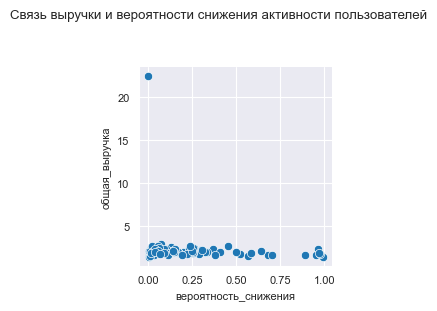

In [46]:
# вывожу график рассеяния
sns.pairplot(only_devices_clients, x_vars='вероятность_снижения', y_vars='общая_выручка')
plt.suptitle(f'Связь выручки и вероятности снижения активности пользователей', y=1.2)
plt.show()

У клиентов, которые покупают технику, в общем низкая вероятность снижения активности. В целом клиенты остаются лояльными. Это можно объяснить тем, что любители техники регулярно покупают технические новинки или запчасти для оборудования. 

## Общий вывод

Для заказчика надо было разработать модель, которая бы предсказывала снижение активности клиентов в последующие 3 месяца. Предсказания нужно было сделать на данных о поведении покупателя на сайте, коммуникациях с покупателем и его продуктовом поведении, выручке, которую получает магазин с покупателя, и времени, которое покупатель провёл на сайте в течение периода. 

Исходные данные я предобработала:

- поправила типы данных,
- убрала неявные дубликаты,
- исправила названия некоторых категорий.

Чтобы найти лучшую модель, я написала пайплайн перебора моделей и их гиперпараметров:

1. В общем пайплайне для подготовки данных кодировала категориальные значения и масштабировала количественные. Использовала два кодировщика (`OneHotEncoder`, `OrdinalEncoder`) и скейлер (`StandardScaler`). 
2. Обучила четыре модели (`KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LogisticRegression()`, `SVC()`) и перебрала для них гиперпараметры.

Лучшей оказалась модель SVC со следующими гиперпараметрами: C=0.1, gamma=10, kernel='linear', MinMaxScaler(). Модель показывает, что активность будет снижаться у клиентов с низкими показателями просмотренных категорий и страниц и времени, проведённого на сайте. Также чем больше у клиента купленных акционных товаров и неоплаченных продуктов в корзине, тем выше вероятность снижения его активности в следующие месяцы. Чтобы увеличить количество времени, проведённого на сайте, можно дополнительно проанализировать популярные категории у клиентов и присылать им предложения по товарам в этих категориях. Можно ещё прокачать категорию «Похоже на то, что вы смотрите сейчас», это может увеличить проведённое время на сайте.

Исследовала также клиентов, которые покупают в основном технику в маркетплейсе. У них в общем низкая вероятность снижения активности и они остаются лояльными. Это можно объяснить тем, что любители техники регулярно покупают технические новинки или запчасти для оборудования. Чтобы их удержать, можно устраивать регулярные акции на запчасти к купленной ими технике или рассылать информацию о технических новинках в области того оборудования, которое они чаще всего покупают.

In [47]:
revenue_sum

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
...,...,...
1295,216643,4.44
1296,216644,6.11
1297,216645,3.29
1298,216646,4.03
